# Fragment library analysis

## Aim of this notebook

This notebook contains the code that was used to calculate most of the statistics as well as to generate the respective plots shown in the manuscript. 

## Table of contents

1. Fragment library
2. Original ligands
3. Ligand occupancy across subpockets
4. Subpocket connectivity across subpockets
5. Fragment occurrence per subpocket
6. Fragment properties per subpocket
7. Fragment similarity per subpocket
8. Fragment promiscuity
9. Draw ligand and fragments for GitHub README figure

In [1]:
%load_ext autoreload
%autoreload 2

Install the Table of Contents extension for JupyterLab for easy navigation through this notebook: https://github.com/jupyterlab/jupyterlab-toc

[Note this was already recommended in the README, so you might want to ommit the next line of code]

In [2]:
from collections import Counter
from pathlib import Path

import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, PandasTools
from IPython.core.display import HTML

from kinfraglib import utils

In [3]:
# Needed to display ROMol images in DataFrames
PandasTools.RenderImagesInAllDataFrames(images=True)

In [4]:
HERE = Path(_dh[-1])
PATH_DATA = HERE / '../data'

## 1. Fragment library

### Load fragment library

Let's load the fragment library (in different formats for different kind of analysis later on):

- `fragment_library`: Dictionary of fragments (values as DataFrame) by subpockets (keys).
- `fragment_library_concat`: All fragments in one DataFrame.
- `fragment_library_concat_wo_x`: All fragments except fragments from pool X in one DataFrame.

**Load fragment library's subpocket pools: `fragment_library`**

`fragment_library` is a dictionary containing a `pandas` DataFrame for each of the six subpockets (AP, FP, SE, GA, B1, B2) and the pool X.

The following data is linked to each fragment:

- `ROMol`, `ROMol_dummy`, and `ROMol_original`: RDKit molecules for the 2D representation of the fragment without and with dummy atoms as well as for the 3D representation of the fragment as described in the SDF file from which the data is loaded.
- `kinase`, `family`, and `group`: *Kinase* name, *family* and *group* of the kinase that the ligand (from which the fragment originates) was co-crystallized with
- `complex_pdb`, `ligand_pdb`, `alt`, and `chain`: *PDB complex* and *ligand ID*, *alternate model* and *chain* for the KLIFS structure that the ligand (from which the fragment originates) was co-crystallized with
- `atom_subpockets`: Subpocket assignment for each of the fragment's atoms
- `atom_environments`: BRICS environment IDs for each of the fragment's atoms
- `smiles` and `smiles_dummy`: SMILES for the fragment without and with dummy atoms
- `subpocket`: Subpocket assignment for the fragment

In [5]:
# Get fragment library by subpocket
fragment_library = utils.read_fragment_library(PATH_DATA / 'fragment_library')

In [6]:
# Output info in library
print(fragment_library.keys())
print(fragment_library['AP'].columns)
print(f'Example fragments for subpocket AP:')
# NBVAL_CHECK_OUTPUT

dict_keys(['AP', 'FP', 'SE', 'GA', 'B1', 'B2', 'X'])
Index(['ROMol', 'ROMol_dummy', 'ROMol_original', 'kinase', 'family', 'group',
       'complex_pdb', 'ligand_pdb', 'alt', 'chain', 'atom_subpockets',
       'atom_environments', 'smiles', 'smiles_dummy', 'subpocket'],
      dtype='object')
Example fragments for subpocket AP:


,ROMol,ROMol_dummy,ROMol_original,kinase,family,group,complex_pdb,ligand_pdb,alt,chain,atom_subpockets,atom_environments,smiles,smiles_dummy,subpocket
0,,,,AAK1,NAK,Other,5l4q,LKB,A,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP F...,16 16 16 16 16 16 16 16 16 16 16 16 16 5 5 na na,Nc1c[nH]c2ncccc12,[11*]c1cnc2[nH]cc(N[27*])c2c1,AP
1,,,,AAK1,NAK,Other,5te0,XIN,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,7 16 7 16 16 16 16 5 16 16 16 16 16 5 5 5 5 5 ...,N/C(=C1\C(=O)Nc2ccccc21)c1ccccc1,[12*]N/C(=C1\C(=O)Nc2cc([20*])ccc21)c1ccccc1,AP

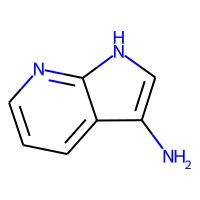
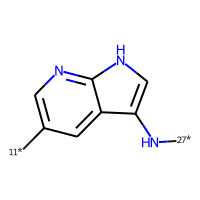
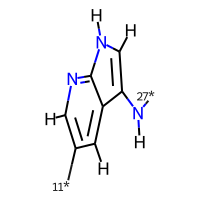
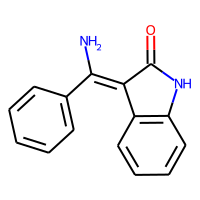
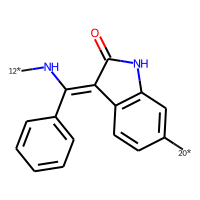
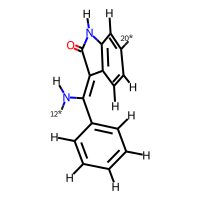

In [7]:
fragment_library['AP'].head(2)

**Load fragment library in one DataFrame: `fragment_library_concat` and `fragment_library_concat_wo_x`**

In [8]:
fragment_library_concat = pd.concat(fragment_library.values())

,ROMol,ROMol_dummy,ROMol_original,kinase,family,group,complex_pdb,ligand_pdb,alt,chain,atom_subpockets,atom_environments,smiles,smiles_dummy,subpocket
0,,,,AAK1,NAK,Other,5l4q,LKB,A,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP F...,16 16 16 16 16 16 16 16 16 16 16 16 16 5 5 na na,Nc1c[nH]c2ncccc12,[11*]c1cnc2[nH]cc(N[27*])c2c1,AP
1,,,,AAK1,NAK,Other,5te0,XIN,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,7 16 7 16 16 16 16 5 16 16 16 16 16 5 5 5 5 5 ...,N/C(=C1\C(=O)Nc2ccccc21)c1ccccc1,[12*]N/C(=C1\C(=O)Nc2cc([20*])ccc21)c1ccccc1,AP

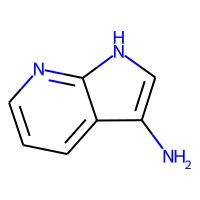
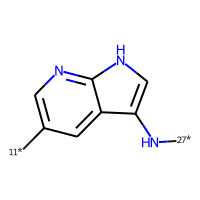
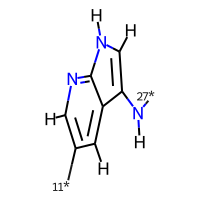
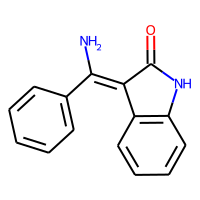
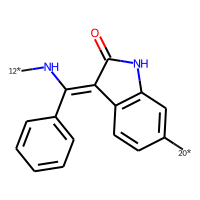
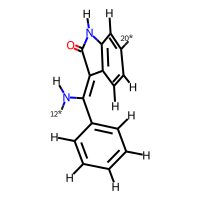

In [9]:
HTML(fragment_library_concat.head(2).to_html(notebook=True))

`fragment_library_concat_wo_x` is `fragment_library_concat` without fragments from pool X.

In [10]:
# Remove pool X
fragment_library_concat_wo_x = fragment_library_concat[
    fragment_library_concat.subpocket != 'X'
].copy()

### Get fragment library overview

How many fragments (with and without pool X) do we have?

In [11]:
# Number of fragments in all fragment subpocket pools
n_fragments = fragment_library_concat.shape[0]

# Number of fragments in all fragment subpocket pools except pool X
n_fragments_wo_x = fragment_library_concat_wo_x.shape[0]

print(f'Number of fragments in library: {n_fragments}')
print(f'Number of fragments in library without pool X: {n_fragments_wo_x}')
# NBVAL_CHECK_OUTPUT

Number of fragments in library: 9505
Number of fragments in library without pool X: 9131


From how many original ligands do these come from?

In [12]:
# Deduplicate these strings in order to get the number of ligands from which the fragments originate
n_original_ligands = fragment_library_concat.groupby(
    ['kinase', 'complex_pdb', 'ligand_pdb']
).size().shape[0]

print(f'Number of original ligands (from which fragments originate): {n_original_ligands}')
# NBVAL_CHECK_OUTPUT

Number of original ligands (from which fragments originate): 3232


## 2. Original ligands

Load original ligands from file. 

Fragment library is grouped by ligand, each ligand is linked to the following data:

- PDB complex and ligand ID, alternate model, chain, and aC-helix conformation for the KLIFS structure that the ligand (from which the fragment originates) was co-crystallized with
- Kinase name, family, and group of the kinase the ligand (from which the fragment originates) was co-crystallized with
- Subpockets occupied by the ligand
- Ligand RDKit molecule (remote KLIFS access) and SMILES (generated from RDKit molecule)

Check out notebook `2_1_fragment_analysis_original_ligands.ipynb` for details on data construction.

In [13]:
original_ligands = pd.read_json(PATH_DATA / 'fragment_library' / 'original_ligands.json')
PandasTools.AddMoleculeColumnToFrame(original_ligands, 'smiles')

print(original_ligands.shape)
# NBVAL_CHECK_OUTPUT

(3231, 13)


,complex_pdb,ligand_pdb,subpocket,kinase,family,group,alt,chain,ac_helix,klifs_id,smiles,inchi,ROMol
0,1a9u,SB2,"[AP, GA, B2]",p38a,MAPK,CMGC,-,A,in,5229,C[S@](=O)c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc3)...,InChI=1S/C21H16FN3OS/c1-27(26)18-8-4-16(5-9-18...,
1,1agw,SU2,"[AP, SE]",FGFR1,FGFR,TK,B,B,in,3510,O=CN1CCN(c2ccc(C[C@@H]3C(=O)Nc4ccccc43)cc2)CC1,InChI=1S/C20H21N3O2/c24-14-22-9-11-23(12-10-22...,

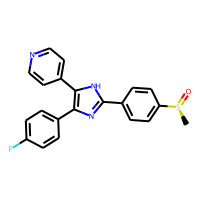
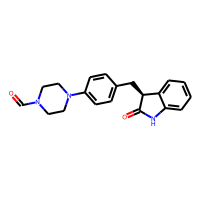

In [14]:
HTML(original_ligands.head(2).to_html(notebook=True))

## 3. Ligand occupancy across subpockets

Calculate the number of subpockets a ligand is occupying. 

(Here, it is not of interest how often a subpocket is occupied by a ligand. Thus, we keep only one entry per ligand and subpocket.)

In [15]:
n_subpockets_per_ligand = fragment_library_concat_wo_x.groupby(
    ['kinase', 'complex_pdb', 'ligand_pdb', 'subpocket']
).first().reset_index().groupby(
    ['kinase', 'complex_pdb', 'ligand_pdb']
).size()

In [16]:
n_subpockets_per_ligand_distribution = pd.concat(
    [
        n_subpockets_per_ligand.value_counts().sort_index().rename('ligand_count'),
        n_subpockets_per_ligand.value_counts(normalize=True).sort_index().rename('ligand_frequency')*100
    ],
    axis=1
)

In [17]:
print('Number of subpockets per ligand (distribution):')
n_subpockets_per_ligand_distribution
# NBVAL_CHECK_OUTPUT

Number of subpockets per ligand (distribution):


,ligand_count,ligand_frequency
1,147,4.548267
2,964,29.826733
3,1639,50.711634
4,435,13.459158
5,44,1.361386
6,3,0.092822


**Creates Figure 3.A in manuscript**

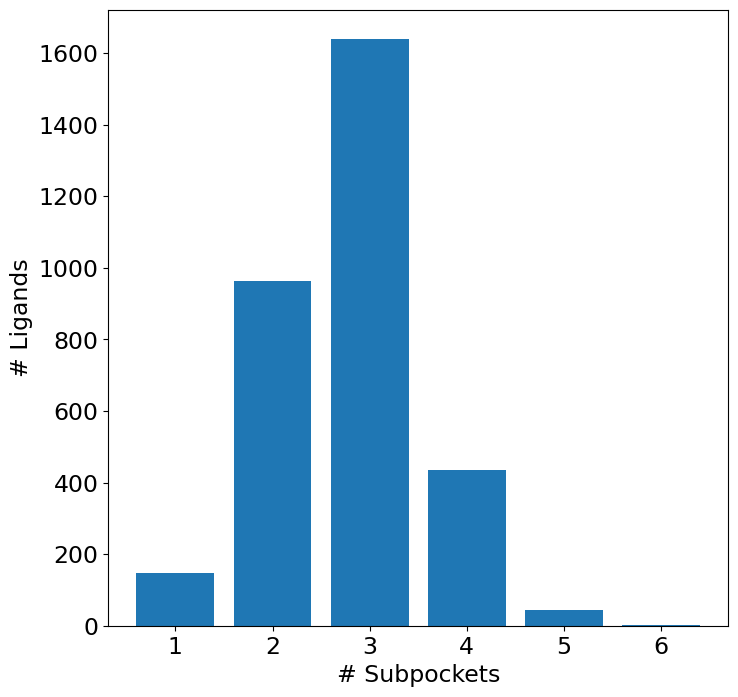

In [18]:
utils.plot_n_subpockets(n_subpockets_per_ligand_distribution)

### Examples for a few special cases of ligands/fragments discussed in the manuscript

#### Ligands occupying 6 subpockets

Could equally be adapted to get samples for ligands occupying less subpockets.

In [19]:
ligand_of_interest_six = n_subpockets_per_ligand[n_subpockets_per_ligand == 6].reset_index()
ligand_of_interest_six
# NBVAL_CHECK_OUTPUT

,kinase,complex_pdb,ligand_pdb,0
0,ALK,4fnz,NZF,6
1,EGFR,6wak,TQA,6
2,MER,7olx,VK5,6


**Creates Figure S1.A in supporting information**

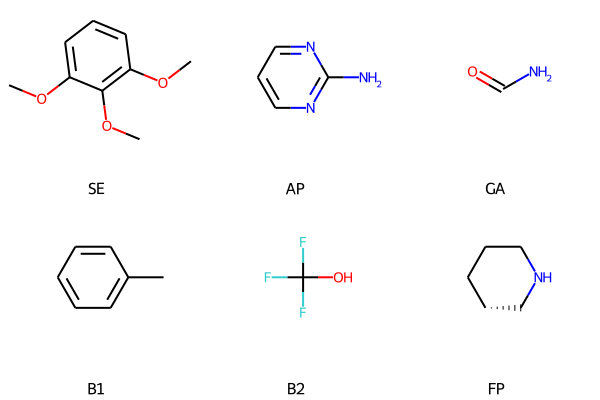

In [20]:
image_six_subpockets = utils.draw_fragmented_ligand(
    fragment_library, 
    ligand_of_interest_six.complex_pdb.values[0], 
    ligand_of_interest_six.ligand_pdb.values[0],
    mols_per_row=3
)
image_six_subpockets.save('figures/extreme_subpockets_six_fragments.png')
image_six_subpockets

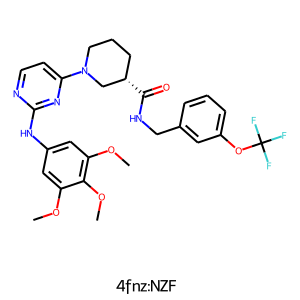

In [21]:
image_ligand_from_pdb_ids = utils.draw_ligands_from_pdb_ids('4fnz', 'NZF', sub_img_size=(300,300))
image_ligand_from_pdb_ids.save('figures/extreme_subpockets_six_ligand.png')
image_ligand_from_pdb_ids

#### Unfragmented ligands

Collect all ligands that only cover one subpocket.

In [22]:
ligand_of_interest_one = n_subpockets_per_ligand[n_subpockets_per_ligand == 1].reset_index()

In [23]:
# Get info for those ligands
unfragmented_ligands = []

for index, row in ligand_of_interest_one.iterrows():
    
    unfragmented_ligands.append(
        utils.get_fragmented_ligand(
            fragment_library, 
            row.complex_pdb, 
            row.ligand_pdb
        )
    )
    
unfragmented_ligands = pd.concat(unfragmented_ligands)

In [24]:
unfragmented_ligands.shape
# NBVAL_CHECK_OUTPUT

(147, 15)

In [25]:
n_heavy_atoms_unfragmented_fragments = unfragmented_ligands.apply(lambda x: x.ROMol.GetNumHeavyAtoms(), axis=1).mean()
n_heavy_atoms_ap_fragments = fragment_library['AP'].apply(lambda x: x.ROMol.GetNumHeavyAtoms(), axis=1).mean()

print(f'Mean number of heavy atoms in unfragmented ligands: {n_heavy_atoms_unfragmented_fragments}')
print(f'Mean number of heavy atoms in AP fragments: {n_heavy_atoms_ap_fragments}')
# NBVAL_CHECK_OUTPUT

Mean number of heavy atoms in unfragmented ligands: 15.510204081632653
Mean number of heavy atoms in AP fragments: 11.144444444444444


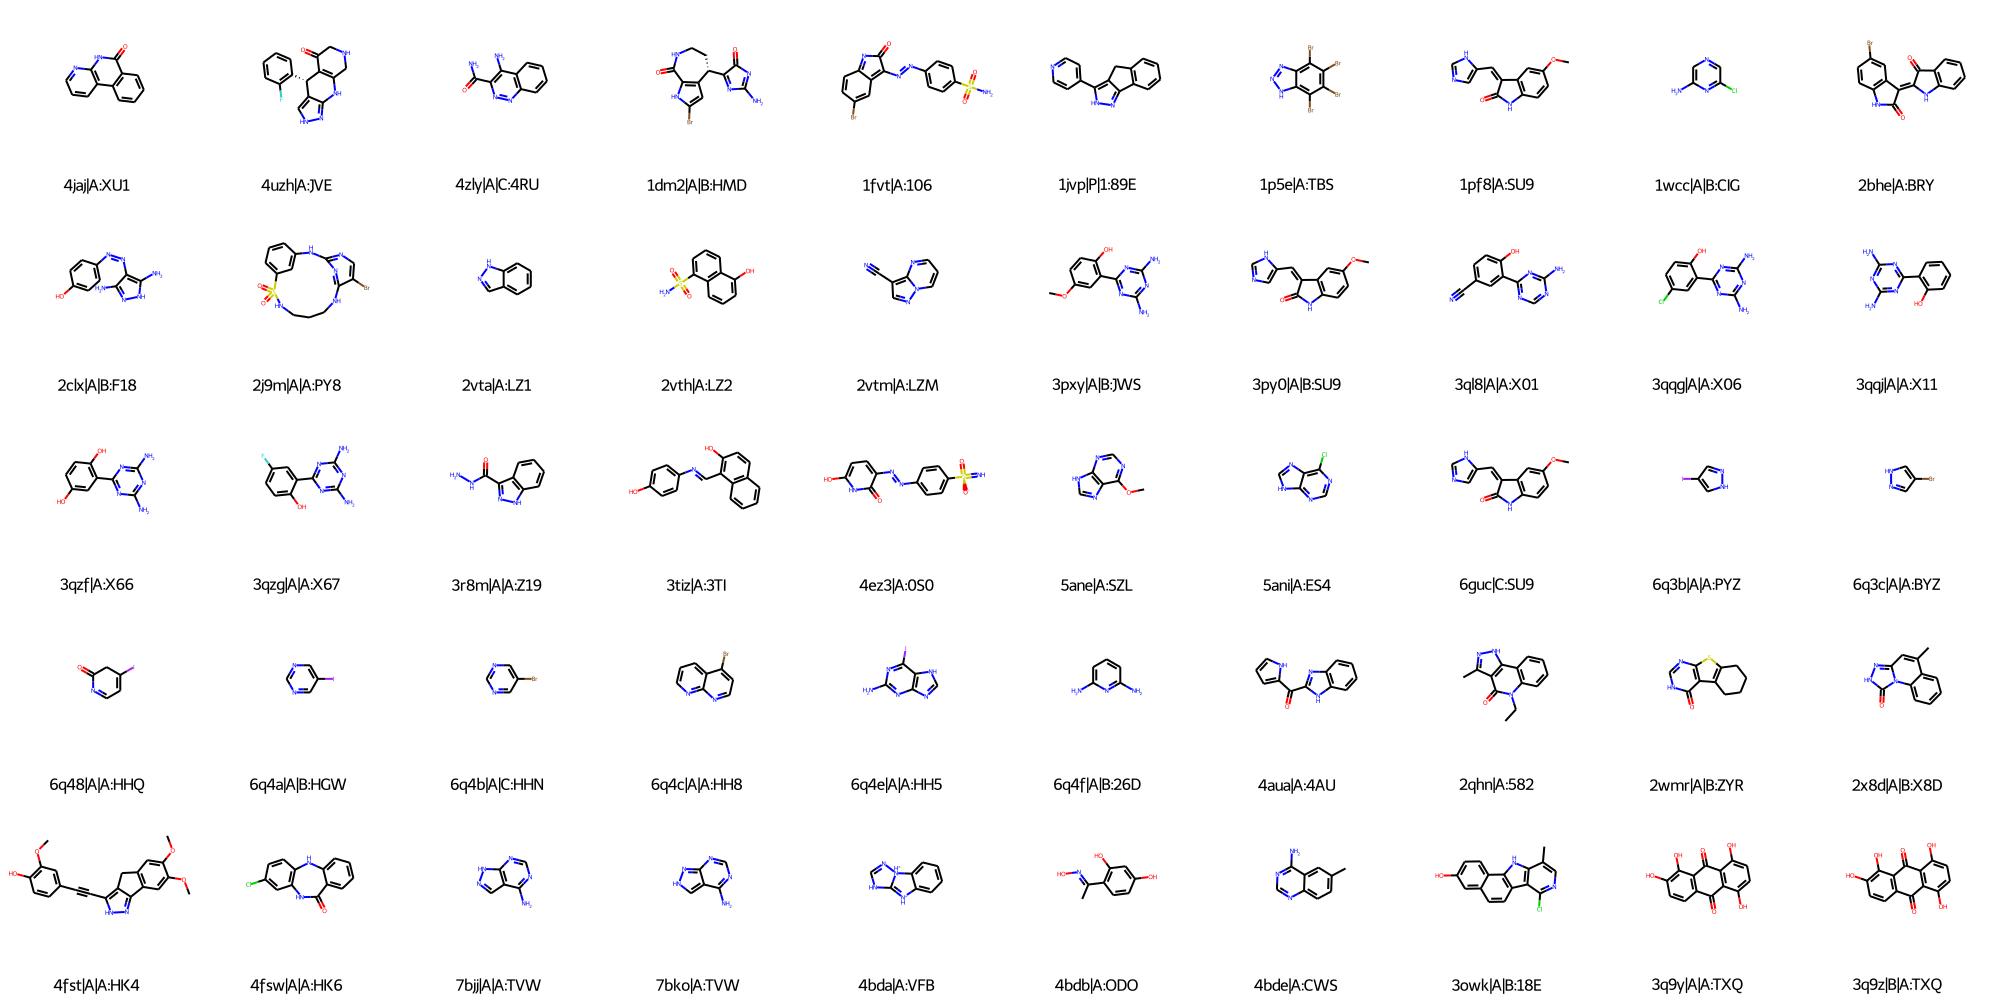

In [26]:
# Draw and save those ligands
image_unfragmented = utils.draw_fragments(unfragmented_ligands[:50], mols_per_row=10)
image_unfragmented.save('figures/extreme_subpockets_one.png')
image_unfragmented

#### Are unfragmented ligands substructures of other original ligands?

In [27]:
# Takes 1-2 minutes
unfragmented_in_original_ligands = []
unfragmented_as_substructure_in_original_ligands = []

for i, unfragmented_ligand in unfragmented_ligands.iterrows():
    for j, original_ligand in original_ligands.iterrows():
        
        template = original_ligand.ROMol
        pattern = unfragmented_ligand.ROMol
        match = template.HasSubstructMatch(pattern)

        if match:
            substructure = template.GetSubstructMatch(pattern)

            # Unfragmented ligand is the full original ligand
            if len(substructure) == template.GetNumAtoms():
                unfragmented_in_original_ligands.append([i, pattern, j, template, substructure])
            
            # Unfragmented ligand is substructure of original ligand
            else:
                unfragmented_as_substructure_in_original_ligands.append([i, pattern, j, template, substructure])
                
unfragmented_in_original_ligands = pd.DataFrame(
    unfragmented_in_original_ligands, 
    columns=['fragment_ix', 'fragment', 'ligand_ix', 'ligand', 'substructure']
)

unfragmented_as_substructure_in_original_ligands = pd.DataFrame(
    unfragmented_as_substructure_in_original_ligands, 
    columns=['fragment_ix', 'fragment', 'ligand_ix', 'ligand', 'substructure']
)

**Unfragmented ligands in original ligands**

Did the substructure search find all original ligands that were not fragmented?

In [28]:
print(f'Number of unfragmented ligands: {len(unfragmented_ligands)}')
print(f'Number of unfragmented ligands that were found in original ligands (sanity check): {len(unfragmented_in_original_ligands.fragment_ix.unique())}')
# NBVAL_CHECK_OUTPUT

Number of unfragmented ligands: 147
Number of unfragmented ligands that were found in original ligands (sanity check): 147


**Unfragmented ligands that are substructures of other original ligands**

In [29]:
unfragmented_as_substructure_in_original_ligands_unique = unfragmented_as_substructure_in_original_ligands.groupby("fragment_ix").first().reset_index()

In [30]:
print(f'Number of unfragmented ligands that are substructure of original ligands: '
      f'{unfragmented_as_substructure_in_original_ligands_unique.shape[0]}'' of 'f'{len(unfragmented_ligands)}'
)
print(f'Percentage of unfragmented ligands that are substructure of original ligands: '
      f'{unfragmented_as_substructure_in_original_ligands_unique.shape[0] / len(unfragmented_ligands)}'
)
# NBVAL_CHECK_OUTPUT

Number of unfragmented ligands that are substructure of original ligands: 39 of 147
Percentage of unfragmented ligands that are substructure of original ligands: 0.2653061224489796


,fragment_ix,fragment,ligand_ix,ligand,substructure
0,291,,1609,,"(19, 17, 23, 10, 12, 15, 18, 20, 21, 22, 11, 1..."
1,404,,702,,"(10, 12, 14, 8, 6, 7, 16, 4, 5, 9, 11, 13, 15)"

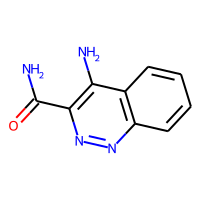
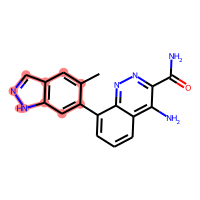
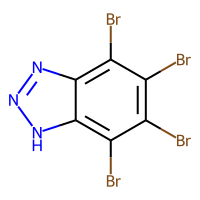
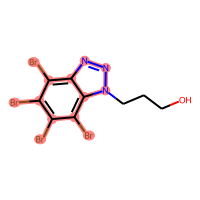

In [31]:
# Note, figure with more annotations will be found below
HTML(unfragmented_as_substructure_in_original_ligands_unique.head(2).to_html(notebook=True))

**Are these substructures fragment-like?**

'Fragment-like' definition taken from https://europepmc.org/article/med/14554012

In [32]:
fragment_likeness = [
    utils.get_ro3_from_mol(row.fragment) 
    for index, row 
    in unfragmented_as_substructure_in_original_ligands_unique.iterrows()
]
fragment_likeness = pd.concat(fragment_likeness, axis=1).transpose()
fragment_likeness.head()

# Number of fulfilled rules (all rules)
fragment_likeness['n_fulfilled_extended'] = fragment_likeness.apply(sum, axis=1)

# Number of fulfilled rules (only basic rules: mw, logp, hbd, hba)
fragment_likeness['n_fulfilled_basic'] = fragment_likeness.apply(lambda x: x.mw + x.logp + x.hba + x.hbd, axis=1)

fragment_likeness.head()
# NBVAL_CHECK_OUTPUT

,mw,logp,hbd,hba,nrot,psa,n_fulfilled_extended,n_fulfilled_basic
0,1,1,1,0,1,0,4,3
1,0,0,1,1,1,1,4,2
2,1,1,1,1,1,1,6,4
3,1,1,1,1,1,1,6,4
4,1,1,1,1,1,1,6,4


In [33]:
print(f'Ratio of unfragmented ligands (that are substructures of other ligands) that are fragment-like (fulfill RO3 for mw, logp and hba/d): '
      f'{fragment_likeness.groupby("n_fulfilled_basic").size()[4] / fragment_likeness.shape[0]}'
)
# NBVAL_CHECK_OUTPUT

Ratio of unfragmented ligands (that are substructures of other ligands) that are fragment-like (fulfill RO3 for mw, logp and hba/d): 0.5128205128205128


**Draw fragment matches**

Labels refer to " unfragmented ligand index | number of fulfilled RO3 rules (mw, logp, hba/d, psa, nrot) | number of fulfilled RO3 rules (mw, logp, hba/d)"


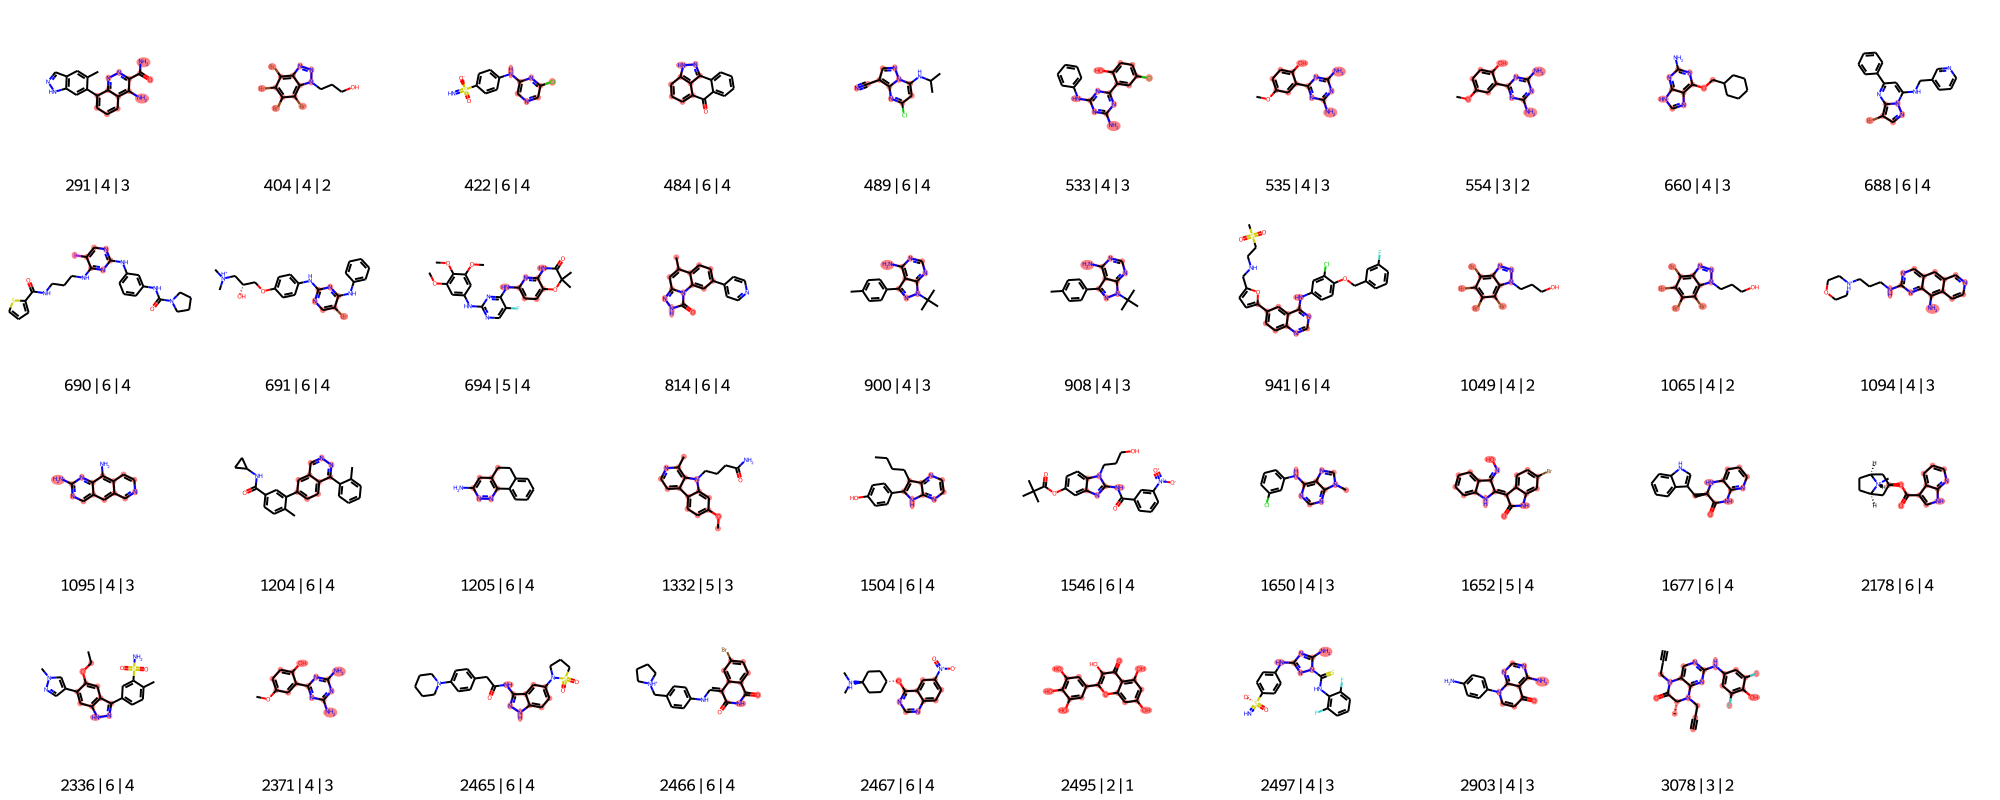

In [34]:
mols = list(unfragmented_as_substructure_in_original_ligands_unique.ligand)
highlight_atom_lists = list(unfragmented_as_substructure_in_original_ligands_unique.substructure)
legends = [
    f'{fragment_ix} | {n_fulfilled_ro3_extended} | {n_fulfilled_ro3_basic}' 
    for fragment_ix, n_fulfilled_ro3_extended, n_fulfilled_ro3_basic
    in zip(
        list(unfragmented_as_substructure_in_original_ligands_unique.fragment_ix), 
        list(fragment_likeness['n_fulfilled_extended']), 
        list(fragment_likeness['n_fulfilled_basic'])
    )
]

print(f'Labels refer to " unfragmented ligand index | number of fulfilled RO3 rules (mw, logp, hba/d, psa, nrot) | number of fulfilled RO3 rules (mw, logp, hba/d)"')

Draw.MolsToGridImage(
    mols, 
    highlightAtomLists=highlight_atom_lists,
    legends=legends,
    molsPerRow=10
)

#### Examples for unfragmented ligands in paper

In [35]:
def draw_selected_fragments(selected_fragments, fragments, mols_per_row=3, max_mols=50):
    """
    Draw fragments selected by complex and ligand PDB ID.
    
    Parameters
    ----------
    selected_fragments : list of list of str
        List of fragments defined by complex and ligand PDB ID.
    fragments : pandas.DataFrame
        Fragments (including data like complex and ligand PDB ID, chain ID, and alternate model).
    mols_per_row : 
        Number of molecules per row.
    max_mols : int
        Number of molecules displayed.
        
    Returns
    -------
    PIL.PngImagePlugin.PngImageFile
        Image of selected fragments.
    """

    # Create DataFrame
    selected_fragments = pd.DataFrame(
        selected_fragments, 
        columns=['complex_pdb', 'ligand_pdb']
    )

    # Merge selected fragments with full fragment table in order to get full details on selected fragments
    selected_fragments = pd.merge(
        selected_fragments, 
        fragments, 
        left_on=['complex_pdb', 'ligand_pdb'],
        right_on=['complex_pdb', 'ligand_pdb'],
        how='left'
    )

    # Draw selected fragments
    image = utils.draw_fragments(selected_fragments, mols_per_row, max_mols)

    return image

**Creates Figure S1.B-D in supporting information**

In [36]:
unfragmented_ligands_paper_b = [
    ['6q3b', 'PYZ'], 
    ['6q3c', 'BYZ'], 
    ['6q48', 'HHQ'],
    ['6q4a', 'HGW'],
    ['6q4b', 'HHN'], 
    ['6q4c', 'HH8'],
    ['6q4e', 'HH5'],
    ['6q4f', '26D']
]
unfragmented_ligands_paper_c = [
    ['3q9y', 'TXQ'],
    ['5j1w', '6FB'],
    ['2o63', 'MYC']
]
unfragmented_ligands_paper_d = [
    ['4fst', 'HK4'], 
    ['3fyj', 'B97'],
    ['6cfm', 'EA7']
]

**(B1-B8) Fragment-like ligands**

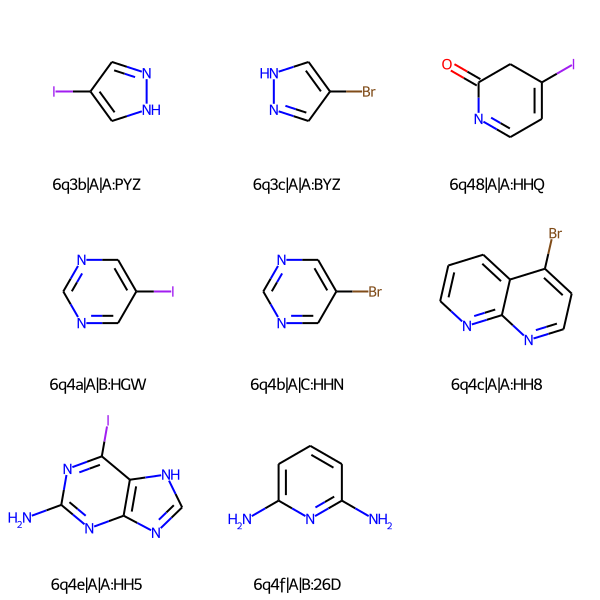

In [37]:
image_unfragmented_paper_b = draw_selected_fragments(
    unfragmented_ligands_paper_b, 
    unfragmented_ligands
)
image_unfragmented_paper_b.save('figures/extreme_subpockets_one_paper_b.png')
image_unfragmented_paper_b

**(C1-C3) Rigid/many fused rings containing ligands**

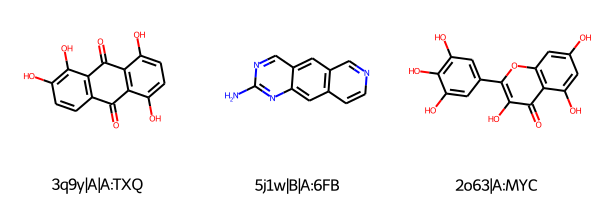

In [38]:
image_unfragmented_paper_c = draw_selected_fragments(
    unfragmented_ligands_paper_c, 
    unfragmented_ligands
)
image_unfragmented_paper_c.save('figures/extreme_subpockets_one_paper_c.png')
image_unfragmented_paper_c

**(D1-D3) Other larger unfragmented ligands**

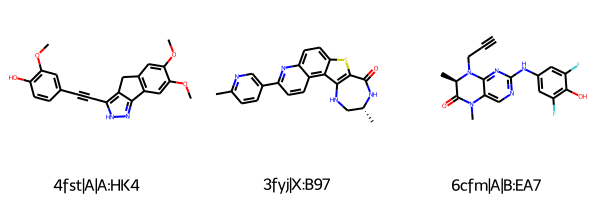

In [39]:
image_unfragmented_paper_d = draw_selected_fragments(
    unfragmented_ligands_paper_d, 
    unfragmented_ligands
)
image_unfragmented_paper_d.save('figures/extreme_subpockets_one_paper_d.png')
image_unfragmented_paper_d

## 4. Subpocket connectivity across subpockets

What subpocket connections do we see how often (connection as in a connection between 2 subpockets)? 

Respective information is stored in 'connections' column of `connections_by_fragment` (for all fragments in all subpockets except pool X).

### Connections per fragment

For each fragment, list all neighboring subpockets (`connections`), e.g. `[FP, SE]`, and all connections between the fragment's subpocket and its neighboring subpockets (`connections_name`), e.g. `[AP=FP, AP=SE]`, respectively.

In [40]:
connections_by_fragment = utils.get_connections_by_fragment(fragment_library_concat)
print(connections_by_fragment.shape)
# NBVAL_CHECK_OUTPUT

(9505, 7)


Look at fragments for a few example ligands (special cases): 
- `5te0` (with a fragment in pool X)
- `5ew9` (with two fragments occupying the same subpocket, connected to the same subpocket)
- `4yjq` (with two fragments occupying the same subpocket, connected to two different subpockets)

In [41]:
connections_by_fragment[connections_by_fragment.complex_pdb == '5te0']
# NBVAL_CHECK_OUTPUT

,kinase,complex_pdb,ligand_pdb,atom_subpockets,connections,connections_name,subpocket
1,AAK1,5te0,XIN,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,"[SE, GA]","[AP=SE, AP=GA]",AP
1,AAK1,5te0,XIN,SE SE SE SE SE SE SE SE SE SE SE SE SE SE SE S...,"[X, AP]","[SE=X, AP=SE]",SE
0,AAK1,5te0,XIN,GA GA GA GA GA GA GA AP,[AP],[AP=GA],GA
0,AAK1,5te0,XIN,X-SE X-SE X-SE X-SE X-SE X-SE X-SE X-SE X-SE X...,[SE],[SE=X],X


In [42]:
connections_by_fragment[connections_by_fragment.complex_pdb == '5ew9']
# NBVAL_CHECK_OUTPUT

,kinase,complex_pdb,ligand_pdb,atom_subpockets,connections,connections_name,subpocket
199,AurA,5ew9,5VC,AP AP AP AP AP AP AP AP AP SE,[SE],[AP=SE],AP
126,AurA,5ew9,5VC,FP FP FP FP FP FP FP FP FP FP FP FP FP FP FP F...,"[SE, SE]","[FP=SE, FP=SE]",FP
168,AurA,5ew9,5VC,SE SE SE SE SE SE SE SE SE SE SE SE AP FP,"[AP, FP]","[AP=SE, FP=SE]",SE
169,AurA,5ew9,5VC,SE SE SE FP,[FP],[FP=SE],SE


In [43]:
connections_by_fragment[connections_by_fragment.complex_pdb == '4yjq']
# NBVAL_CHECK_OUTPUT

,kinase,complex_pdb,ligand_pdb,atom_subpockets,connections,connections_name,subpocket
2834,SYK,4yjq,4DK,AP AP AP AP AP AP AP AP AP AP GA SE,"[GA, SE]","[AP=GA, AP=SE]",AP
2110,SYK,4yjq,4DK,FP FP FP FP FP FP FP FP FP FP SE,[SE],[FP=SE],FP
2111,SYK,4yjq,4DK,FP FP FP FP FP FP FP FP FP FP FP GA,[GA],[FP=GA],FP
1714,SYK,4yjq,4DK,SE SE SE SE SE SE SE SE SE SE AP FP,"[AP, FP]","[AP=SE, FP=SE]",SE
1084,SYK,4yjq,4DK,GA GA GA GA GA GA GA GA GA GA GA GA GA GA GA F...,"[FP, AP]","[FP=GA, AP=GA]",GA


### Connections per ligand

Pool fragment connections by ligand: Each ligand will have each connection listed twice. For example, in a ligand with the two fragments in `AP` and `SE`, the two connecting fragments `AP` and `SE` will both be associated by the connections `AP=SE`. After pooling fragment connections by ligand, the ligand will have listed the connections `['AP=SE', 'AP=SE']`.

In [44]:
connections_by_ligand = connections_by_fragment.groupby(
    ['kinase', 'complex_pdb', 'ligand_pdb']
)['connections_name'].sum()
connections_by_ligand
# NBVAL_CHECK_OUTPUT

kinase  complex_pdb  ligand_pdb
AAK1    5l4q         LKB                         [AP=FP, AP=SE, AP=FP, AP=SE]
        5te0         XIN             [AP=SE, AP=GA, SE=X, AP=SE, AP=GA, SE=X]
        8gmc         YFV                         [AP=FP, AP=FP, AP=FP, AP=FP]
        8gmd         ZRR           [AP=GA, AP=FP, FP=GA, AP=FP, AP=GA, FP=GA]
ABL1    2f4j         VX6           [AP=SE, FP=GA, FP=SE, AP=SE, FP=SE, FP=GA]
                                                      ...                    
p70S6K  4l44         5FI                           [AP=FP, AP=FP, FP=X, FP=X]
        4l45         5FI                           [AP=FP, AP=FP, FP=X, FP=X]
        4l46         5FI                           [AP=FP, AP=FP, FP=X, FP=X]
        7n91         1RJ                                       [AP=FP, AP=FP]
        7n93         1SK                           [AP=FP, AP=FP, FP=X, FP=X]
Name: connections_name, Length: 3232, dtype: object

**Sanity check**: This also means, that all fragment connections for each ligand must have an even count. Check:

In [45]:
connections_by_ligand_count = connections_by_ligand.apply(lambda x: Counter(x))
connections_by_ligand_count.head()
# NBVAL_CHECK_OUTPUT

kinase  complex_pdb  ligand_pdb
AAK1    5l4q         LKB                       {'AP=FP': 2, 'AP=SE': 2}
        5te0         XIN            {'AP=SE': 2, 'AP=GA': 2, 'SE=X': 2}
        8gmc         YFV                                   {'AP=FP': 4}
        8gmd         ZRR           {'AP=GA': 2, 'AP=FP': 2, 'FP=GA': 2}
ABL1    2f4j         VX6           {'AP=SE': 2, 'FP=GA': 2, 'FP=SE': 2}
Name: connections_name, dtype: object

In [46]:
# Are there any ligands that have an odd count for a connection? (That would point to a problem in the data.)
connections_by_ligand_count[
    ~connections_by_ligand_count.apply(
        lambda x: all([i%2 == 0 for i in list(x.values())])
    )
]
# NBVAL_CHECK_OUTPUT

Series([], Name: connections_name, dtype: object)

Good, all ligands show an even count for each connection. Continue.

### Connection frequencies

How often is a certain connection (e.g. `AP=FP`) across all ligands? 

For this analysis, each connection is only considered once per ligand (even if a ligand has multiple e.g. `AP=FP` connections), hence only the presence or absence is considered per ligand.

In [47]:
# Get connection count across ligands (count each connection per ligand only once)
connections_across_ligands_count = pd.Series(Counter(connections_by_ligand_count.apply(list).sum()))
connections_across_ligands_count.name = 'count'

# Get connection frequency (100% = all ligands)
connections_across_ligands_frequency = connections_across_ligands_count.apply(lambda x: round((x / connections_by_ligand_count.shape[0] * 100), 1))
connections_across_ligands_frequency.name = 'frequency'

# Concatenate count and frequency data to DataFrame
connections_across_ligands = pd.concat([connections_across_ligands_count, connections_across_ligands_frequency], axis=1)
connections_across_ligands.sort_values(by='count', ascending=False)
# NBVAL_CHECK_OUTPUT

,count,frequency
AP=FP,2011,62.2
AP=SE,1899,58.8
AP=GA,1172,36.3
FP=GA,257,8.0
FP=SE,226,7.0
FP=X,174,5.4
SE=X,172,5.3
B1=GA,125,3.9
B2=GA,100,3.1
B1=B2,13,0.4


## 5. Fragments occurrence per subpocket

### Deduplicated fragments (per subpocket)

Deduplicate fragmentes per subpocket based on their SMILES.

In [48]:
# Collect all fragments and deduplicated version of them
n_fragments_per_subpocket = [len(fragments) for subpocket, fragments in fragment_library.items()]
n_fragments_per_subpocket_deduplicated = [len(fragments.drop_duplicates('smiles')) for subpocket, fragments in fragment_library.items()]

In [49]:
# Get fragments numbers per subpocket
stats_n_fragments = pd.DataFrame(
    {
        'n_fragments': n_fragments_per_subpocket,
        'n_fragments_deduplicated': n_fragments_per_subpocket_deduplicated,
        'freq_duplicates': [(i-j) / i * 100 for i, j in zip(n_fragments_per_subpocket, n_fragments_per_subpocket_deduplicated)]
    },
    index=fragment_library.keys()
)
stats_n_fragments
# NBVAL_CHECK_OUTPUT

,n_fragments,n_fragments_deduplicated,freq_duplicates
AP,3240,1327,59.043210
FP,2385,1101,53.836478
SE,1962,743,62.130479
GA,1305,355,72.796935
B1,126,47,62.698413
B2,113,60,46.902655
X,374,140,62.566845


In [50]:
print(f'Mean duplicates frequency across subpockets: {stats_n_fragments.freq_duplicates.mean()}')
# NBVAL_CHECK_OUTPUT

Mean duplicates frequency across subpockets: 59.99643061689665


**Distribution of fragments across the different subpockets**

In [51]:
pd.DataFrame(
    {
        'freq_fragments': [i / sum(n_fragments_per_subpocket[:-1]) * 100 for i in n_fragments_per_subpocket[:-1]],
        'freq_fragments_deduplicated': [i / sum(n_fragments_per_subpocket_deduplicated[:-1]) * 100 for i in n_fragments_per_subpocket_deduplicated[:-1]]
    },
    index=list(fragment_library.keys())[:-1]
)
# NBVAL_CHECK_OUTPUT

,freq_fragments,freq_fragments_deduplicated
AP,35.483518,36.526287
FP,26.119812,30.305533
SE,21.487241,20.451418
GA,14.291972,9.771539
B1,1.379915,1.293697
B2,1.237542,1.651528


In [52]:
print(f'Number of fragments (wo X): {sum(n_fragments_per_subpocket[:-1])}')
print(f'Number of deduplicated fragments (wo X): {sum(n_fragments_per_subpocket_deduplicated[:-1])}')
# NBVAL_CHECK_OUTPUT

Number of fragments (wo X): 9131
Number of deduplicated fragments (wo X): 3633


**Creates Figure 3.B in manuscript**

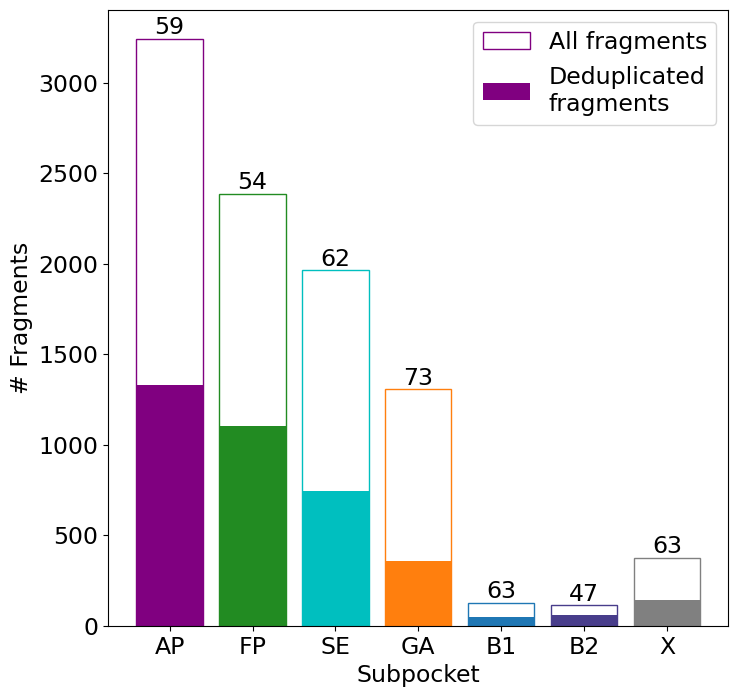

In [53]:
utils.plot_n_fragments_per_subpocket(n_fragments_per_subpocket, n_fragments_per_subpocket_deduplicated)

### Ligands with multiple fragments per subpocket

1. How many ligands have fragments occupying the same subpocket multiple times?
2. How many ligands have fragments occupying the same subpocket *and thereby connecting to the same neighbor subpocket*?

Ligands from question 2 are a subset of ligands from question 1. Example `5ew9` covers both questions:

In [54]:
connections_by_fragment[connections_by_fragment.complex_pdb == '5ew9']
# NBVAL_CHECK_OUTPUT

,kinase,complex_pdb,ligand_pdb,atom_subpockets,connections,connections_name,subpocket
199,AurA,5ew9,5VC,AP AP AP AP AP AP AP AP AP SE,[SE],[AP=SE],AP
126,AurA,5ew9,5VC,FP FP FP FP FP FP FP FP FP FP FP FP FP FP FP F...,"[SE, SE]","[FP=SE, FP=SE]",FP
168,AurA,5ew9,5VC,SE SE SE SE SE SE SE SE SE SE SE SE AP FP,"[AP, FP]","[AP=SE, FP=SE]",SE
169,AurA,5ew9,5VC,SE SE SE FP,[FP],[FP=SE],SE


Perform the following calculations without pool X: Everything that cannot be assigned to a subpocket is dumped in pool X. Therefore, connections to pool X do not necessarily represent real connections.

In [55]:
connections_by_fragment_wo_x = connections_by_fragment[connections_by_fragment.subpocket != 'X'].copy()

**1. How many ligands have fragments occupying the same subpocket multiple times?**

In [56]:
# Count number of fragments per subpocket and ligand (exclude pool X)
n_fragments_per_subpocket_and_ligand = connections_by_fragment_wo_x.groupby(
    ['kinase', 'complex_pdb', 'ligand_pdb', 'subpocket']
).size() 
n_fragments_per_subpocket_and_ligand.name = 'counts'

In [57]:
print(f'Number of ligands have fragments occupying the same subpocket multiple times:')
n_fragments_per_subpocket_and_ligand[n_fragments_per_subpocket_and_ligand > 1].shape[0]
# NBVAL_CHECK_OUTPUT

Number of ligands have fragments occupying the same subpocket multiple times:


160

More detail: Check per subpocket, how often it is occupied once, twice, or more times across all ligands:

In [58]:
n_fragments_per_subpocket_and_ligand.reset_index().groupby(['subpocket', 'counts']).size()
# NBVAL_CHECK_OUTPUT

subpocket  counts
AP         1         3224
           2            8
B1         1          126
B2         1          113
FP         1         2124
           2          129
           3            1
GA         1         1301
           2            2
SE         1         1922
           2           20
dtype: int64

Get that ligand that occupies a subpocket three times...

In [59]:
n_fragments_per_subpocket_and_ligand[n_fragments_per_subpocket_and_ligand == 3]
# NBVAL_CHECK_OUTPUT

kinase  complex_pdb  ligand_pdb  subpocket
PLK1    2yac         937         FP           3
Name: counts, dtype: int64

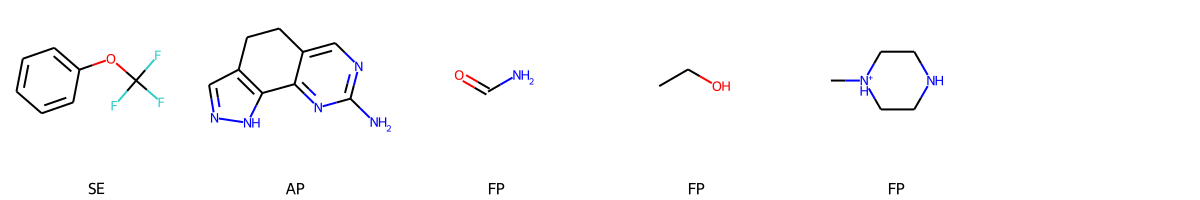

In [60]:
utils.draw_fragmented_ligand(fragment_library, '2yac', '937')

Check out complex structure in KLIFS: https://klifs.vu-compmedchem.nl/details.php?structure_id=4957

**How many ligands have fragments occupying the same subpocket and thereby connecting to the same neighbor subpocket?**

In [61]:
# Fragments that have multipe connections to the same subpocket
fragments_multiple_connections_to_same_subpocket = connections_by_fragment_wo_x[
    connections_by_fragment_wo_x.apply(
        lambda x: len(x.connections) != len(set(x.connections)),
        axis=1
    )
]

In [62]:
print(f'Number of ligands have fragments occupying the same subpocket and thereby connecting to the same neighbor subpocket:')
fragments_multiple_connections_to_same_subpocket.groupby(
    ['kinase', 'complex_pdb', 'ligand_pdb']
).size().shape[0]
# NBVAL_CHECK_OUTPUT

Number of ligands have fragments occupying the same subpocket and thereby connecting to the same neighbor subpocket:


94

## 6. Fragment properties per subpocket

### Duplicates

Discussed in *8. Fragment promiscuity*.

### Physicochemical properties

Get descriptors for fragments per subpocket (deduplicated per subpocket):

In [63]:
descriptors = utils.get_descriptors_by_fragments(fragment_library)

In [64]:
descriptors.drop('smiles', axis=1).drop('mol', axis=1).groupby('subpocket').median()
# NBVAL_CHECK_OUTPUT

,# HBD,# HBA,LogP,# Heavy atoms
subpocket,,,,
AP,1.0,3.0,1.22060,12.0
B1,0.0,1.0,1.17850,8.0
B2,0.0,1.0,1.10362,9.0
FP,1.0,2.0,0.77720,10.0
GA,1.0,1.0,1.40080,9.0
SE,1.0,2.0,1.00710,11.0
X,1.0,1.0,0.52365,7.0


**Creates Figure 5.A in manuscript**

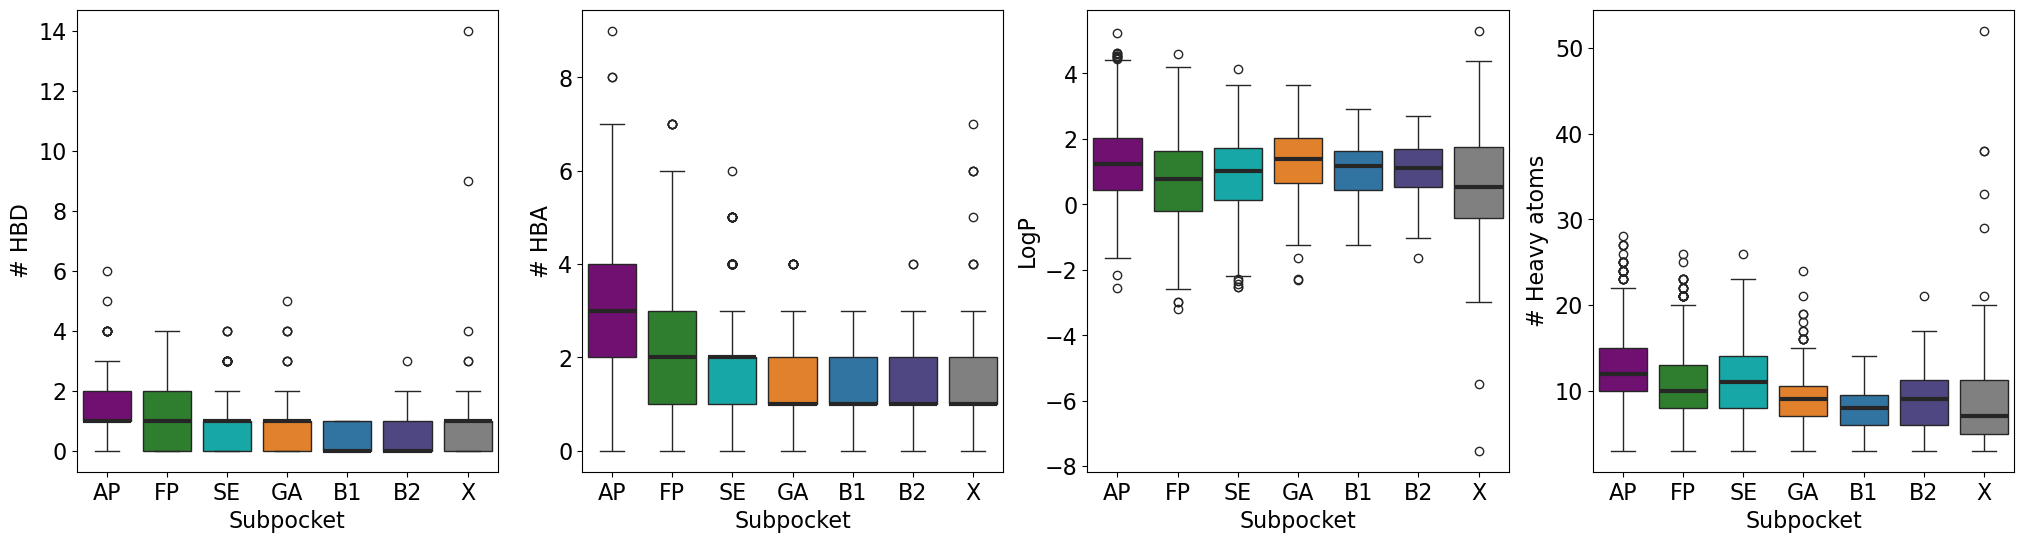

In [65]:
utils.plot_fragment_descriptors(descriptors)

##### Some more details on the descriptor values per subpocket

In [66]:
descriptors.groupby('subpocket')['# HBD'].describe()
# NBVAL_CHECK_OUTPUT

,count,mean,std,min,25%,50%,75%,max
subpocket,,,,,,,,
AP,1327.0,1.299925,0.882471,0.0,1.0,1.0,2.0,6.0
B1,47.0,0.489362,0.505291,0.0,0.0,0.0,1.0,1.0
B2,60.0,0.533333,0.769474,0.0,0.0,0.0,1.0,3.0
FP,1101.0,1.119891,0.874993,0.0,0.0,1.0,2.0,4.0
GA,355.0,0.805634,0.808830,0.0,0.0,1.0,1.0,5.0
SE,743.0,0.839838,0.797520,0.0,0.0,1.0,1.0,4.0
X,140.0,0.907143,1.507279,0.0,0.0,1.0,1.0,14.0


In [67]:
descriptors.groupby('subpocket')['# HBA'].describe()
# NBVAL_CHECK_OUTPUT

,count,mean,std,min,25%,50%,75%,max
subpocket,,,,,,,,
AP,1327.0,3.124341,1.446503,0.0,2.0,3.0,4.0,9.0
B1,47.0,1.297872,0.777814,0.0,1.0,1.0,2.0,3.0
B2,60.0,1.483333,0.965361,0.0,1.0,1.0,2.0,4.0
FP,1101.0,1.977293,1.275087,0.0,1.0,2.0,3.0,7.0
GA,355.0,1.552113,0.953415,0.0,1.0,1.0,2.0,4.0
SE,743.0,1.771198,1.095878,0.0,1.0,2.0,2.0,6.0
X,140.0,1.428571,1.309307,0.0,1.0,1.0,2.0,7.0


In [68]:
descriptors.groupby('subpocket')['LogP'].describe().sort_values('50%')
# NBVAL_CHECK_OUTPUT

,count,mean,std,min,25%,50%,75%,max
subpocket,,,,,,,,
X,140.0,0.629729,1.758052,-7.5286,-0.408975,0.52365,1.764100,5.30610
FP,1101.0,0.710624,1.301472,-3.2074,-0.203900,0.77720,1.633820,4.60112
SE,743.0,0.918197,1.188042,-2.5398,0.138750,1.00710,1.735850,4.13230
B2,60.0,1.067454,0.864280,-1.6339,0.522800,1.10362,1.701975,2.70540
B1,47.0,1.115196,0.942114,-1.2485,0.436700,1.17850,1.631000,2.90130
AP,1327.0,1.282316,1.170249,-2.5461,0.428800,1.22060,2.025960,5.23640
GA,355.0,1.310054,1.019111,-2.3050,0.659810,1.40080,2.026260,3.66202


In [69]:
descriptors.groupby('subpocket')['# Heavy atoms'].describe()
# NBVAL_CHECK_OUTPUT

,count,mean,std,min,25%,50%,75%,max
subpocket,,,,,,,,
AP,1327.0,12.765637,4.034926,3.0,10.0,12.0,15.00,28.0
B1,47.0,7.851064,2.484550,3.0,6.0,8.0,9.50,14.0
B2,60.0,9.083333,4.109896,3.0,6.0,9.0,11.25,21.0
FP,1101.0,10.666667,4.222092,3.0,8.0,10.0,13.00,26.0
GA,355.0,8.940845,3.144252,3.0,7.0,9.0,10.50,24.0
SE,743.0,10.904441,4.024557,3.0,8.0,11.0,14.00,26.0
X,140.0,9.435714,7.008947,3.0,5.0,7.0,11.25,52.0


## 7. Fragment similarity per subpockets

1. Group and deduplicate all fragments by subpocket.
2. Calculate similarities for all pairwise fragment combinations within subpockets.

In [70]:
similarities_per_subpocket = utils.get_fragment_similarity_per_subpocket(fragment_library_concat)
similarities_per_subpocket.head()

,similarity,subpocket
0,0.104987,AP
1,0.095588,AP
2,0.250000,AP
3,0.108247,AP
4,0.059072,AP


**Creates Figure 5.B in manuscript**

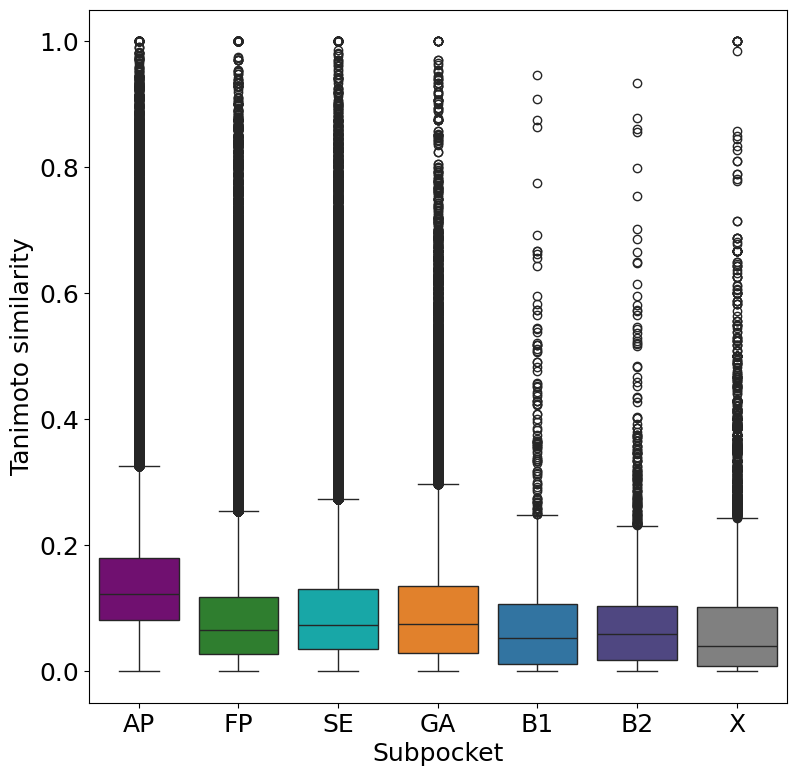

In [71]:
utils.plot_fragment_similarity(similarities_per_subpocket, 'Subpocket')

In [72]:
similarities_per_subpocket.groupby('subpocket', sort=False).mean()
# NBVAL_CHECK_OUTPUT

,similarity
subpocket,
AP,0.142140
FP,0.090011
SE,0.101006
GA,0.104038
B1,0.090624
B2,0.084325
X,0.077321


In [73]:
{key: len(value) for key, value in fragment_library.items()}
# NBVAL_CHECK_OUTPUT

{'AP': 3240,
 'FP': 2385,
 'SE': 1962,
 'GA': 1305,
 'B1': 126,
 'B2': 113,
 'X': 374}

## 8. Fragment promiscuity

### Fragment similarity between and across kinase groups

Are fragments more similar within kinase groups than across kinase groups?

1. Group and deduplicate all fragments by kinase group and subpocket (excluding pool X).
2. Calculate similarities for all pairwise fragment combinations within kinase groups and subpockets (excluding X).
4. Calculate total distribution across all kinase groups (i.e. get all similarities by kinase groups and subpockets for the new kinase group 'Total').

In [74]:
similarities_per_kinase_group = utils.get_fragment_similarity_per_kinase_group(fragment_library_concat_wo_x)
similarities_per_kinase_group.head()

,similarity,group,subpocket
0,0.530864,AGC,AP
1,0.527607,AGC,AP
2,0.464865,AGC,AP
3,0.643411,AGC,AP
4,0.166065,AGC,AP


In [75]:
similarities_per_kinase_group.groupby('group').size()
# NBVAL_CHECK_OUTPUT

group
AGC       10572
CAMK      72319
CK1        1433
CMGC     225619
Other     28160
STE        9583
TK       210384
TKL       15992
Total    574062
dtype: int64

**Creates Figure 5.C in manuscript**

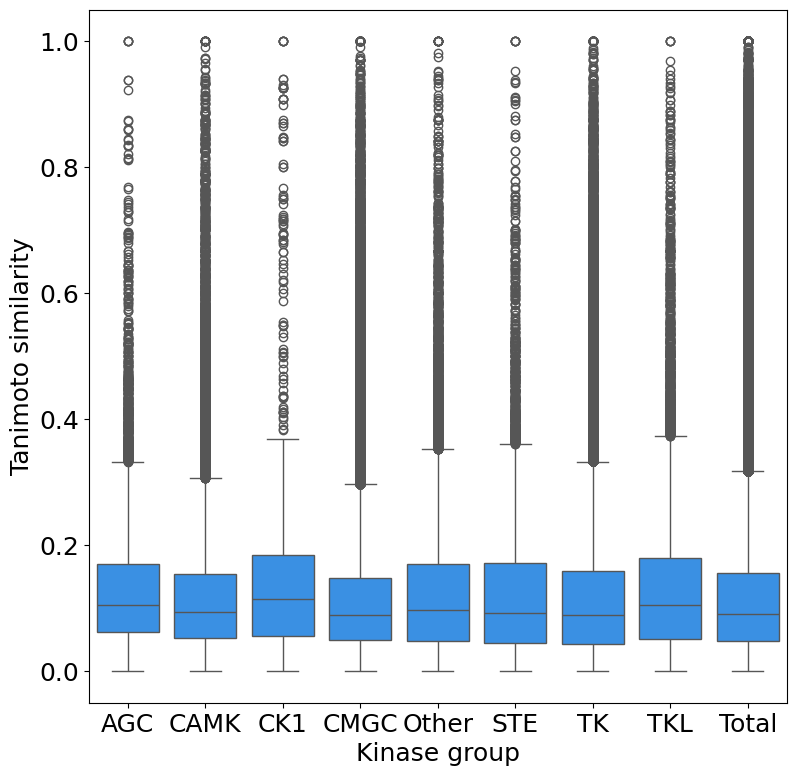

In [76]:
utils.plot_fragment_similarity(similarities_per_kinase_group, 'Kinase group')

In [77]:
similarities_per_kinase_group.drop('subpocket', axis=1).groupby('group', sort=False).mean()
# NBVAL_CHECK_OUTPUT

,similarity
group,
AGC,0.131644
CAMK,0.119291
CK1,0.153783
CMGC,0.112207
Other,0.126162
STE,0.126156
TK,0.118008
TKL,0.132459
Total,0.117169


### Singletons vs. fragments with duplicates in subpocket pool

#### Term definitions

Let's define a few terms first:

* **Singletons**: Fragments' SMILES that appear only once in the dataset (subpocket pool)
* **Fragments with duplicates**: Fragments' SMILES that appear multiple times in the dataset (subpocket pool), i.e. they have duplicates.
* **Deduplicated fragments**: After deduplication of the SMILES in a subpocket pool, each fragments' SMILES will appear only once in the dataset, regardless if it had duplicates before or not: 
  > Number of **deduplicate fragments** = Number of **singletons** (they have no copies) + Number of fragments that have multiple copies (**fragments with duplicates**)

#### Procedure

1. Group fragments by subpocket and their SMILES (groups represent deduplicated fragments).
2. Count how often each fragment's SMILES occurs in the dataset (subpocket pool).
3. Per fragment, save all kinases and kinase groups that it was co-crystallized with. 

In [78]:
fragments_by_subpocket_and_smiles = pd.concat(
    [
        fragment_library_concat.groupby(['subpocket', 'smiles']).size(),
        fragment_library_concat.groupby(['subpocket', 'smiles'])['kinase'].apply(list), 
        fragment_library_concat.groupby(['subpocket', 'smiles'])['group'].apply(list),
    ], 
    axis=1
)
fragments_by_subpocket_and_smiles.rename(columns={0: 'occurrence'}, inplace=True)
fragments_by_subpocket_and_smiles.head()

occurrence  \
subpocket smiles                                     
AP        Brc1c(Br)c(Br)c2[nH]cnc2c1Br           4   
          Brc1c(Br)c(Br)c2[nH]nnc2c1Br           6   
          Brc1c(Br)c(Br)c2n[nH]nc2c1Br           2   
          Brc1ccc2[nH]ccc2c1                     1   
          Brc1ccc2occc2c1                        2   

                                                                           kinase  \
subpocket smiles                                                                    
AP        Brc1c(Br)c(Br)c2[nH]cnc2c1Br               [CK2a1, CK2a1, CK2a1, CK2a2]   
          Brc1c(Br)c(Br)c2[nH]nnc2c1Br  [CDK2, CK2a1, CK2a1, CK2a1, CK2a2, CK2a2]   
          Brc1c(Br)c(Br)c2n[nH]nc2c1Br                             [CK2a1, CK2a1]   
          Brc1ccc2[nH]ccc2c1                                               [PIM1]   
          Brc1ccc2occc2c1                                            [PIM1, PIM1]   

                                                                       group  
subpocket smiles                                                              
AP        Brc1c(Br)c(Br)c2[nH]cnc2c1Br              [CMGC, CMGC, CMGC, CMGC]  
          Brc1c(Br)c(Br)c2[nH]nnc2c1Br  [CMGC, CMGC, CMGC, CMGC, CMGC, CMGC]  
          Brc1c(Br)c(Br)c2n[nH]nc2c1Br                          [CMGC, CMGC]  
          Brc1ccc2[nH]ccc2c1                                          [CAMK]  
          Brc1ccc2occc2c1                                       [CAMK, CAMK]

#### Questions

Data in `fragments_by_subpocket_and_smiles` allows to track the following:

What is the ratio of singletons vs. fragments with duplicates with respect to deduplicated dataset?

1. How many deduplicated fragments are there (within each subpocket)?
2. How many fragments (within subpockets) are singletons?
3. How many fragments (within subpockets) have duplicates?

If fragments occur multiple times in a subpocket pool, do they have a tendency for specific kinases or kinase groups?

4. Based on the fragments with duplicates, how many bind to the same kinase?
5. Based on the fragments with duplicates, how many bind to different kinases?
6. Based on the fragments with duplicates binding to different kinases, how many bind to the same kinase group?
7. Based on the fragments with duplicates binding to different kinases, how many to different kinase groups?

**1. How many deduplicated fragments are there (within each subpocket)?**

In [79]:
fragments_deduplicated = fragments_by_subpocket_and_smiles
fragments_deduplicated.shape[0]
# NBVAL_CHECK_OUTPUT

3773

**2. How many fragments (within subpockets) are singletons?**

In [80]:
fragments_singletons = fragments_by_subpocket_and_smiles[
        fragments_by_subpocket_and_smiles.apply(
        lambda x: len(x.kinase) == 1,
        axis=1
    )
]
fragments_singletons.shape[0]
# NBVAL_CHECK_OUTPUT

2510

**3. How many fragments (within subpockets) are duplicates?**

In [81]:
fragments_duplicates = fragments_by_subpocket_and_smiles[
        fragments_by_subpocket_and_smiles.apply(
        lambda x: len(x.kinase) != 1,
        axis=1
    )
]
fragments_duplicates.shape[0]
# NBVAL_CHECK_OUTPUT

1263

In [82]:
# Collect numbers of singletons vs. fragments with duplicates
fragment_occurrence = pd.DataFrame(
    {
        '# singletons': fragments_singletons.reset_index().groupby('subpocket').size(),
        '# fragments with duplicates': fragments_duplicates.reset_index().groupby('subpocket').size(),
        '# deduplicated fragments': fragments_deduplicated.reset_index().groupby('subpocket').size()
    }
)
fragment_occurrence['% singletons'] = fragment_occurrence['# singletons'] / fragment_occurrence['# deduplicated fragments'] * 100
fragment_occurrence
# NBVAL_CHECK_OUTPUT

,# singletons,# fragments with duplicates,# deduplicated fragments,% singletons
subpocket,,,,
AP,893,434,1327,67.294650
B1,28,19,47,59.574468
B2,41,19,60,68.333333
FP,777,324,1101,70.572207
GA,200,155,355,56.338028
SE,482,261,743,64.872140
X,89,51,140,63.571429


In [83]:
print(f"Average ratio of singletons across subpockets: {fragment_occurrence.drop('X')['% singletons'].mean()}")

Average ratio of singletons across subpockets: 64.49747103842263


**4. Based on the fragments with duplicates, how many bind to the same kinase?**

In [84]:
fragments_duplicates_same_kinase = fragments_by_subpocket_and_smiles[
        fragments_by_subpocket_and_smiles.apply(
        lambda x: (len(x.kinase) != 1) & (len(set(x.kinase)) == 1),
        axis=1
    )
]
fragments_duplicates_same_kinase.shape[0]
# NBVAL_CHECK_OUTPUT

478

**5. Based on the fragments with duplicates, how many bind to different kinases?**

In [85]:
fragments_duplicates_different_kinases = fragments_by_subpocket_and_smiles[
        fragments_by_subpocket_and_smiles.apply(
        lambda x: (len(x.kinase) != 1) & (len(set(x.kinase)) != 1),
        axis=1
    )
]
fragments_duplicates_different_kinases.shape[0]
# NBVAL_CHECK_OUTPUT

785

**6. Based on the fragments with duplicates binding to different kinases, how many bind to the same kinase group?**

In [86]:
fragments_duplicates_different_kinases_same_group = fragments_by_subpocket_and_smiles[
        fragments_by_subpocket_and_smiles.apply(
        lambda x: (len(x.kinase) != 1) & (len(set(x.kinase)) != 1) & (len(set(x.group)) == 1),
        axis=1
    )
]
fragments_duplicates_different_kinases_same_group.shape[0]
# NBVAL_CHECK_OUTPUT

215

**7. Based on the fragments with duplicates to different kinases, how many to different kinase groups?**

In [87]:
fragments_duplicates_different_kinases_and_group = fragments_by_subpocket_and_smiles[
        fragments_by_subpocket_and_smiles.apply(
        lambda x: (len(x.kinase) != 1) & (len(set(x.kinase)) != 1) & (len(set(x.group)) != 1),
        axis=1
    )
]
fragments_duplicates_different_kinases_and_group.shape[0]
# NBVAL_CHECK_OUTPUT

570

**Summarize numbers**

Note: The DataFrames shown below where created in steps 1-7 above.

In [88]:
stats = pd.DataFrame(
    [
        fragments_deduplicated.reset_index().groupby('subpocket').size(),
        fragments_singletons.reset_index().groupby('subpocket').size(),
        fragments_duplicates.reset_index().groupby('subpocket').size(),
        fragments_duplicates_same_kinase.reset_index().groupby('subpocket').size(),
        fragments_duplicates_different_kinases.reset_index().groupby('subpocket').size(),
        fragments_duplicates_different_kinases_same_group.reset_index().groupby('subpocket').size(),
        fragments_duplicates_different_kinases_and_group.reset_index().groupby('subpocket').size(),
    ],
    index=[
        'fragments_deduplicated',
        'fragments_singletons',
        'fragments_duplicates',
        'fragments_duplicates_same_kinase',
        'fragments_duplicates_different_kinases',
        'fragments_duplicates_different_kinases_same_group',
        'fragments_duplicates_different_kinases_and_group',
    ]
)
stats
# NBVAL_CHECK_OUTPUT

subpocket,AP,B1,B2,FP,GA,SE,X
fragments_deduplicated,1327,47,60,1101,355,743,140
fragments_singletons,893,28,41,777,200,482,89
fragments_duplicates,434,19,19,324,155,261,51
fragments_duplicates_same_kinase,185,9,11,116,49,91,17
fragments_duplicates_different_kinases,249,10,8,208,106,170,34
fragments_duplicates_different_kinases_same_group,75,6,2,63,27,36,6
fragments_duplicates_different_kinases_and_group,174,4,6,145,79,134,28


In [89]:
stats.transpose().sum()
# NBVAL_CHECK_OUTPUT

fragments_deduplicated                               3773
fragments_singletons                                 2510
fragments_duplicates                                 1263
fragments_duplicates_same_kinase                      478
fragments_duplicates_different_kinases                785
fragments_duplicates_different_kinases_same_group     215
fragments_duplicates_different_kinases_and_group      570
dtype: int64

In [90]:
print(
    f'Ratio of singletons \n(with respect to deduplicated fragments):\n'
    f'{fragments_singletons.shape[0] / fragments_deduplicated.shape[0]}\n'
)

print(
    f'Ratio of duplicate fragments that bind only to one kinase \n(with respect to deduplicated fragments):\n'
    f'{fragments_duplicates_same_kinase.shape[0] / fragments_deduplicated.shape[0]}\n'
)

print(
    f'Ratio of duplicate fragments that bind to different kinases and kinase groups \n(with respect to deduplicated fragments):\n'
    f'{fragments_duplicates_different_kinases_and_group.shape[0] / fragments_deduplicated.shape[0]}\n'
)

print(
    f'Ratio of duplicate fragments that bind to different kinase groups \n(with respect to fragments that bind to different kinases):\n'
    f'{fragments_duplicates_different_kinases_and_group.shape[0] / fragments_duplicates_different_kinases.shape[0]}\n'
)
# NBVAL_CHECK_OUTPUT

Ratio of singletons 
(with respect to deduplicated fragments):
0.665253114232706

Ratio of duplicate fragments that bind only to one kinase 
(with respect to deduplicated fragments):
0.12668963689371854

Ratio of duplicate fragments that bind to different kinases and kinase groups 
(with respect to deduplicated fragments):
0.15107341637953883

Ratio of duplicate fragments that bind to different kinase groups 
(with respect to fragments that bind to different kinases):
0.7261146496815286



## 9. Miscellaneous

### Draw ligand and fragments for GitHub README figure

In [91]:
complex_pdb = '3w2s'
ligand_pdb = 'W2R'

,ROMol,ROMol_dummy,ROMol_original,kinase,family,group,complex_pdb,ligand_pdb,alt,chain,atom_subpockets,atom_environments,smiles,smiles_dummy,subpocket
1349,,,,EGFR,EGFR,TK,3w2s,W2R,A,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP GA FP,14 14 14 14 14 14 14 14 14 14 14 9 5 5 na na,Nc1ncnc2cc[nH]c12,[23*]Nc1ncnc2ccn([46*])c12,AP
505,,,,EGFR,EGFR,TK,3w2s,W2R,A,A,GA GA GA GA GA GA GA GA GA GA GA B1 AP,16 16 16 16 16 16 16 16 16 3 16 na na,Oc1ccccc1Cl,[24*]Oc1ccc([61*])cc1Cl,GA
50,,,,EGFR,EGFR,TK,3w2s,W2R,A,A,B1 B1 B1 B1 B1 B1 B1 B1 B1 B1 GA B2,16 16 16 16 16 16 16 16 16 16 na na,c1ccccc1,[63*]c1cccc([70*])c1,B1
16,,,,EGFR,EGFR,TK,3w2s,W2R,A,A,B2 B2 B2 B2 B2 B2 B2 B2 B2 B2 B2 B2 B2 B2 B2 B...,1 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15...,NC(=O)NC1CCCCC1,[22*]NC(=O)NC1CCCCC1,B2
935,,,,EGFR,EGFR,TK,3w2s,W2R,A,A,FP FP FP FP FP FP FP FP FP FP FP FP FP FP FP AP,8 4 4 4 4 4 4 4 4 4 4 4 3 3 3 na,CCOCCO,[60*]CCOCCO,FP

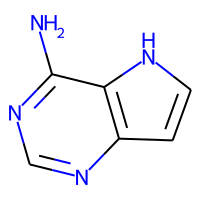
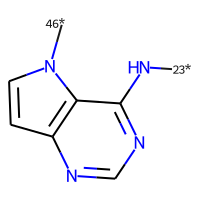
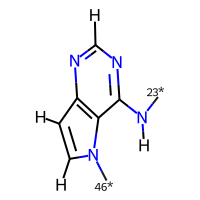
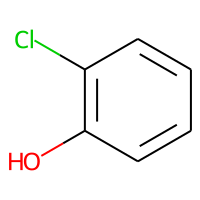
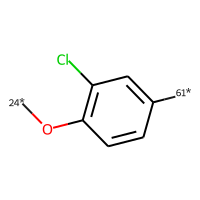
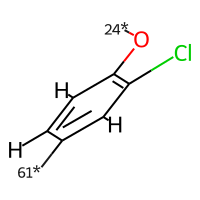
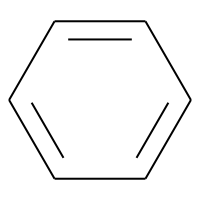
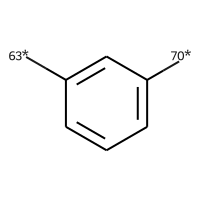
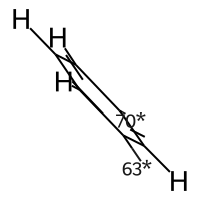
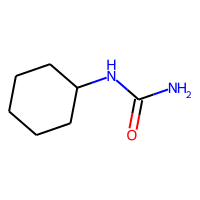
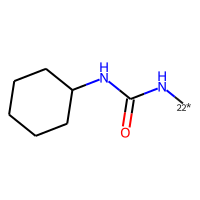
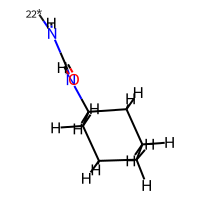
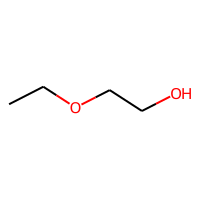
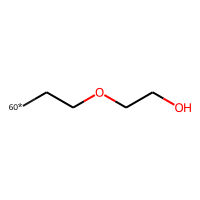
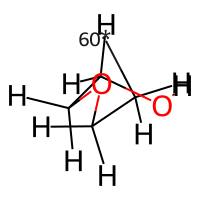

In [92]:
HTML(utils.get_fragmented_ligand(fragment_library, complex_pdb, ligand_pdb).to_html(notebook=True))

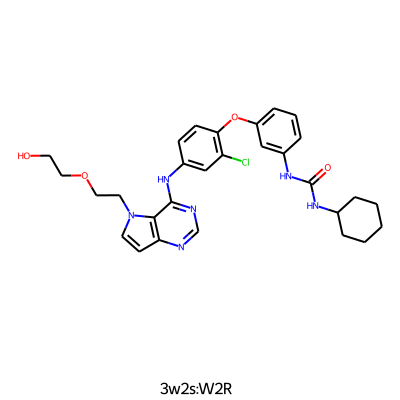

In [93]:
img = utils.draw_ligands_from_pdb_ids(complex_pdb, ligand_pdb, sub_img_size=(400,400), mols_per_row=1)
img.save('figures/ligands_3w2s.png')
img

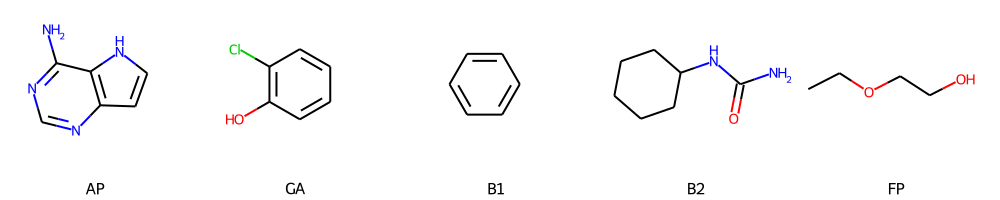

In [94]:
img = utils.draw_fragmented_ligand(fragment_library, complex_pdb, ligand_pdb, mols_per_row=5)
img.save('figures/fragments_3w2s_altA_chainA.png')
img

### Ligands occupying B1/B2 predominantly in aC-out/out-like conformations?

**Goal**: Compare ratio of aC-in/out/out-like ratio for back cleft binders (ligands with fragments in B1 and B2) against front cleft binders, in order to explain why we only have so little ligands reaching subpockets B1 and B2. 
To check if structures with ligands reaching B1 and B2 are enriched in the aC-out/out-like conformations. 

**Note**: The KLIFS database has updated their aC-helix classification, thus the numbers show in the [KinFragLib paper](https://pubs.acs.org/doi/10.1021/acs.jcim.0c00839) do not correspond to the numbers shown in this notebook anymore. See [KLIFS news](https://klifs.net/news.php#) > "Granular control over the kinase conformation" post.

**Old KLIFS aC-classification**

KLIFS definitions for aC-in/out/out-like defined as the distance between Ca atoms of D(xDFG.81) and E(aC.24)
* aC-in: $4-7.2 A$
* aC-out: $9.3-14 A$
* aC-out-like: distances in between

We are adding _by hand_ the results based on the old classification, while fetch the results from the new classification afterwards.

In [95]:
ac_conformations_stats = pd.DataFrame(
    [[1766, 1722, 44], [2, 2, 0], [543, 461, 82], [242, 189, 53]],
    index = ["in", "na", "out", "out-like"],
    columns = ["all ligands", "front cleft binder", "back cleft binder"]
)
ac_conformations_stats

,all ligands,front cleft binder,back cleft binder
in,1766,1722,44
na,2,2,0
out,543,461,82
out-like,242,189,53


In [96]:
round(ac_conformations_stats / ac_conformations_stats.sum(), 2)

,all ligands,front cleft binder,back cleft binder
in,0.69,0.73,0.25
na,0.00,0.00,0.00
out,0.21,0.19,0.46
out-like,0.09,0.08,0.30


**New KLIFS aC-classification**

> To classify the position of the aC-helix regardless of its rotation, it is measured as the distance between the Ca atom of residue 76 to the middle of the Ca atoms of 23-24-25. The latter corresponds roughly to the middle of the aC-helix at the position of the conserved glutamate (residue 24). Two clear distributions were observed for this measure, a distance smaller than $19.6 A$ corresponding to the "int" state of the aC-helix, and a distance higher than this cutoff corresponding to the "out" state. Note: The former intermediate "OUT-like" state of the aC-helix has been removed.

Description taken from [KLIFS website](https://klifs.net/search.php#) > "Conformations" > aC-helix tooltip

In [97]:
b1_or_b2_binders = original_ligands[original_ligands.subpocket.apply(lambda x: ('B1' in x) or ('B2' in x))]
b1_and_b2_non_binders = original_ligands[original_ligands.subpocket.apply(lambda x: ('B1' not in x) and ('B2' not in x))]

In [98]:
ac_conformations_stats = pd.concat(
    [
        original_ligands.groupby('ac_helix').size(),
        b1_and_b2_non_binders.groupby('ac_helix').size(),
        b1_or_b2_binders.groupby('ac_helix').size(),
    ],
    axis=1
)
ac_conformations_stats.rename(columns={0: 'all ligands', 1: 'front cleft binder', 2: 'back cleft binder'}, inplace=True)
ac_conformations_stats.fillna(0, inplace=True)
ac_conformations_stats = ac_conformations_stats.astype('int32')
ac_conformations_stats
# NBVAL_CHECK_OUTPUT

,all ligands,front cleft binder,back cleft binder
ac_helix,,,
in,2621,2495,126
na,5,5,0
out,605,507,98


In [99]:
ac_conformations_stats.sum()
# NBVAL_CHECK_OUTPUT

all ligands           3231
front cleft binder    3007
back cleft binder      224
dtype: int64

Calculate ratios:

In [100]:
round(ac_conformations_stats / ac_conformations_stats.sum(), 2)
# NBVAL_CHECK_OUTPUT

,all ligands,front cleft binder,back cleft binder
ac_helix,,,
in,0.81,0.83,0.56
na,0.00,0.00,0.00
out,0.19,0.17,0.44
